# Analyzing hysteresis loops using the *General T-Q SOM*
This tutorial will demonstrate a basic workflow for analyzing suspended sediment transport hysteresis loops using the pre-trained *General T-Q SOM*. For details on how this SOM was trained, check out our [research paper](https://egusphere.copernicus.org/preprints/2025/egusphere-2025-2146/).  
The workflow will be illustrated using a time series of discharge and turbidity for which a set of hydrologic events where previously delineated. 
   
Beyond `HySOM` (and its dependencies: `numpy`, `matplotlib` and `numba`), `Pandas` is required to run this notebook, so make sure you have it installed.

In [ ]:
from hysom.utils.datasets import get_01191000_qt_data, get_01191000_events_data
from hysom.utils.plots import heat_map, heatmap_frequency
from hysom.pretrainedSOM import get_generalTQSOM
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
from datetime import datetime
import numpy.typing as npt 
from typing import Any 
import pandas as pd
import numpy as np

## Load data
First, let's load a sample dataset included in the `HySOM` package. The dataset contains two main pices of data:  


1. `qt`: Pandas dataframe with time series data of discharge and turbidity
2. `event_times`: list of (`start`,`end`) times for each event

In [29]:
qt = pd.DataFrame(get_01191000_qt_data())
qt.set_index("datetime", inplace=True, drop=True)
event_times = get_01191000_events_data()

print(f"{len(event_times)} events. First 5:")
print(*event_times[:5], sep= "\n")
print("\nTime Series:")
qt.head()


253 events. First 5:
(datetime.datetime(2016, 6, 4, 8, 8, 46, tzinfo=datetime.timezone.utc), datetime.datetime(2016, 6, 9, 6, 2, 42, tzinfo=datetime.timezone.utc))
(datetime.datetime(2016, 6, 9, 19, 8, 42, tzinfo=datetime.timezone.utc), datetime.datetime(2016, 6, 14, 17, 2, 39, tzinfo=datetime.timezone.utc))
(datetime.datetime(2016, 6, 29, 8, 33, 29, tzinfo=datetime.timezone.utc), datetime.datetime(2016, 7, 4, 6, 27, 25, tzinfo=datetime.timezone.utc))
(datetime.datetime(2016, 7, 6, 15, 57, 4, tzinfo=datetime.timezone.utc), datetime.datetime(2016, 7, 9, 9, 27, 2, tzinfo=datetime.timezone.utc))
(datetime.datetime(2016, 7, 9, 11, 16, 12, tzinfo=datetime.timezone.utc), datetime.datetime(2016, 7, 11, 20, 34, 55, tzinfo=datetime.timezone.utc))

Time Series:


,Qcms,turb
datetime,,
2016-05-31 21:15:00+00:00,0.387941,2.4
2016-05-31 21:30:00+00:00,0.387941,2.5
2016-05-31 21:45:00+00:00,0.370951,2.3
2016-05-31 22:00:00+00:00,0.370951,2.3
2016-05-31 22:15:00+00:00,0.370951,2.3


### Plot data:

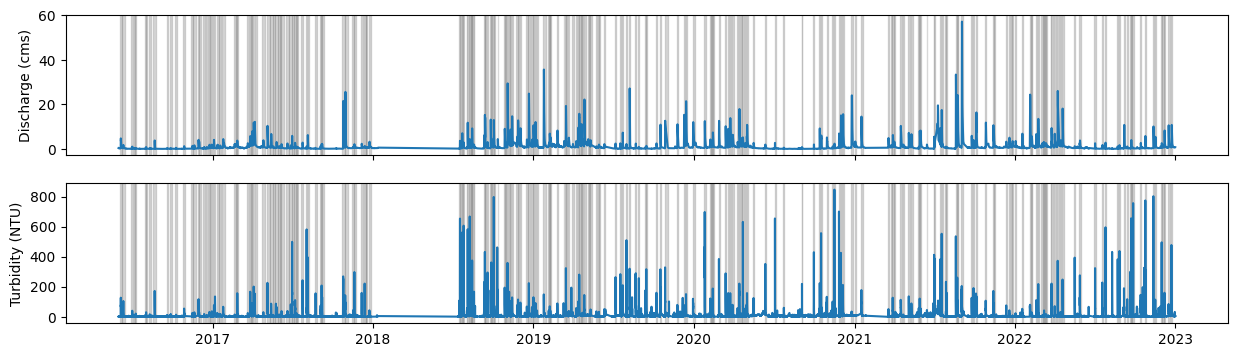

In [18]:

fig, (axq, axt) = plt.subplots(2,1, sharex = True, figsize = (15,4))

axq.plot(qt["Qcms"])
axq.set_ylabel("Discharge (cms)")
axt.plot(qt["turb"])
axt.set_ylabel("Turbidity (NTU)")

for start, end in event_times:
    for ax in [axq, axt]:
        ax.axvspan(xmin = start, xmax = end, alpha = 0.3, color = "grey")



## Preprocess data
Let's prepare the data to make it compatible with HSOM. For a detailed explanation of the preprocessing steps check out [this tutorial](https://hysom.readthedocs.io/en/latest/tutorials/preparingInputData.html)

To facilitate the analysis, I'll first define a helper function to interpolate C-Q data (`loop_interpolation`) and a data structure to easily store and access event information including starting and end dates, the corresponding hysteresis loop and additional attributes (`Event`):

In [ ]:
def loop_interpolation(CQtimeSeries: pd.DataFrame, seq_length) -> np.ndarray:
    """
    Interpolates a hysteresis loop in the C-Q plane to make it compatible with `HSOM`. 
    The resulting loop will have `seq_length` evenly spaced data points.
    Note that the interpolation procedure ignores time information

    Parameters:
    - CQtimeSeries (pd.DataFrame): Pandas DataFrame with two columns. Typically: (discharge, concentration)
    - seq-length (int): number  
    
    Returns:
    - np.ndarray: Numpy array of shape seq_length x 2 with the interpolated sequence

    """
    col1, col2 = CQtimeSeries.columns
    accum_dists = ( (CQtimeSeries[col1] - CQtimeSeries.shift(1)[col1])**2 + (CQtimeSeries[col2] - CQtimeSeries.shift(1)[col2])**2).apply(np.sqrt).cumsum()
    accum_dists.iloc[0] = 0.0
    path_length = accum_dists.max()
    
    interp_dists = np.linspace(0,path_length, seq_length)
    
    col1_interp = np.interp(interp_dists, accum_dists, CQtimeSeries[col1])
    col2_interp = np.interp(interp_dists, accum_dists, CQtimeSeries[col2])
    
    return np.stack((col1_interp, col2_interp), axis = 1)

@dataclass
class Event:
    start: datetime
    end: datetime
    loop: npt.ArrayLike = field(repr=False)
    attributes: dict[str, Any] = field(default_factory=dict, repr=False)

    def get_attribute(self, key: str, default: Any = None):
        return self.attributes.get(key, default)

    def set_attribute(self, key: str, val: Any):
        self.attributes[key] = val

Extract loops and some atrributes (maximum discharge and turbidity) for each event and store them in a list:

In [ ]:
loops_and_metrics = []
events = []
for start, end in event_times:
    qtevent = qt[start:end]
    qtnormalized = (qtevent - qtevent.min()) / (qtevent.max() - qtevent.min())
    loop = loop_interpolation(qtnormalized, 100)
    qmax = qtevent["Qcms"].max()
    turbmax = qtevent["turb"].max()
    events.append(Event(start = start, end = end, loop=loop, attributes={"qmax":qmax, "turbmax":turbmax}))


Let's visualize some loops

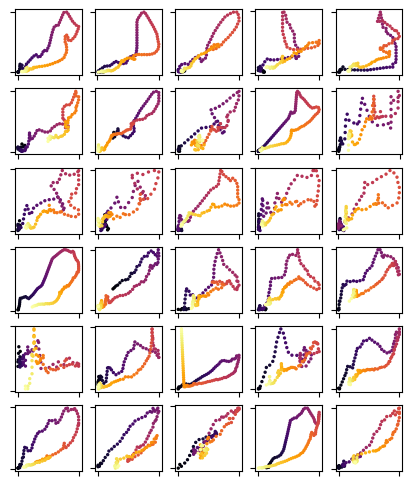

In [9]:
fig, axs = plt.subplots(6,5, figsize = (5,6))

for event, ax in zip(events[:30], axs.flatten()):
    loop = event.loop
    ax.scatter(loop[:,0], loop[:,1], cmap = "inferno", c = range(len(loop)), s = 2)
    ax.tick_params(labelbottom = False, labelleft = False)

## Analyze the data with the *General T-Q SOM*
### Let's load the *General T-Q SOM* first

In [19]:
TQsom = get_generalTQSOM()

Plot the frequency distribution including all loops:

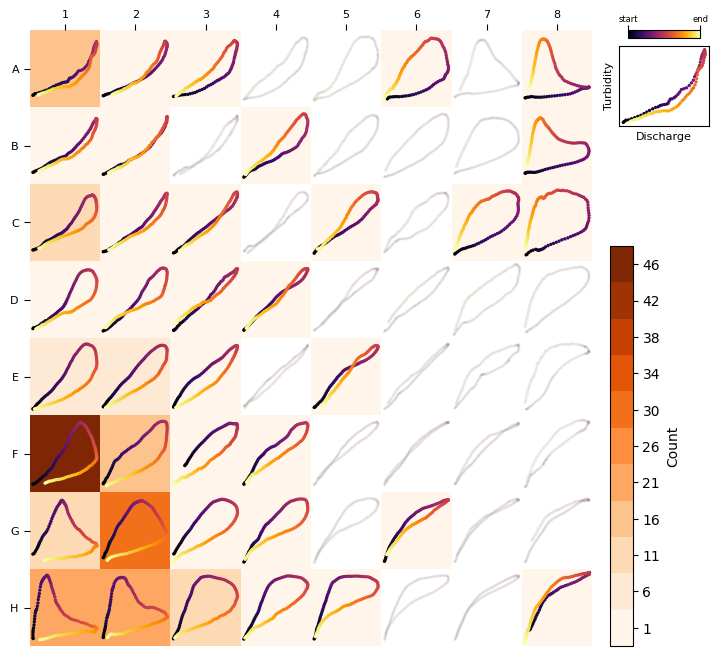

In [20]:
heatmap_frequency(TQsom, [ev.loop for ev in events])

Now, let's add a couple more attributes to each event: the `bmu` and the `distance_to_bmu` as measured by the distance function (in this case: **DTW**, [See more details in our research paper and SI](https://egusphere.copernicus.org/preprints/2025/egusphere-2025-2146/)) 

In [32]:
for ev in events:
    ev.set_attribute("bmu",TQsom.get_BMU(ev.loop))
    ev.set_attribute("distance_to_bmu",TQsom.get_distance_to_bmu(ev.loop))



See below the frequency distribution of `distance_to_bmu` values. Note that this distance measures the similarity between a loop and its associated BMU, with larger distances indicating less similarity. Loops that are too different from their BMU should be filter out to reduce noise and misleading results.

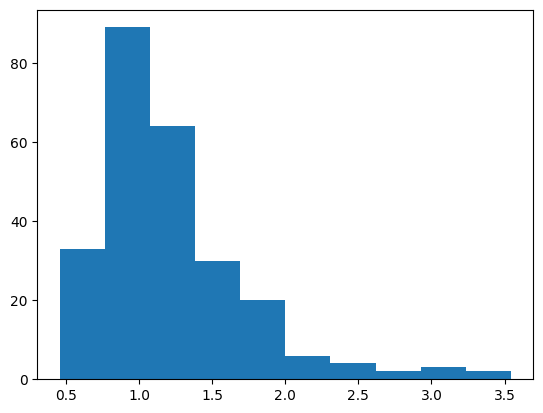

In [33]:
_ = plt.hist([ev.get_attribute("distance_to_bmu") for ev in events])

Let's use a threshold of 1.5 as an acceptable value (this is a rough estimate. In a real analysis you want to find a value that works for you)

In [35]:
filtered_events = list(filter(lambda x: x.get_attribute("distance_to_bmu") < 1.5, events))

print(f"{len(filtered_events)} valid events")

197 valid events


See below the frequency distribution with the filtered data:

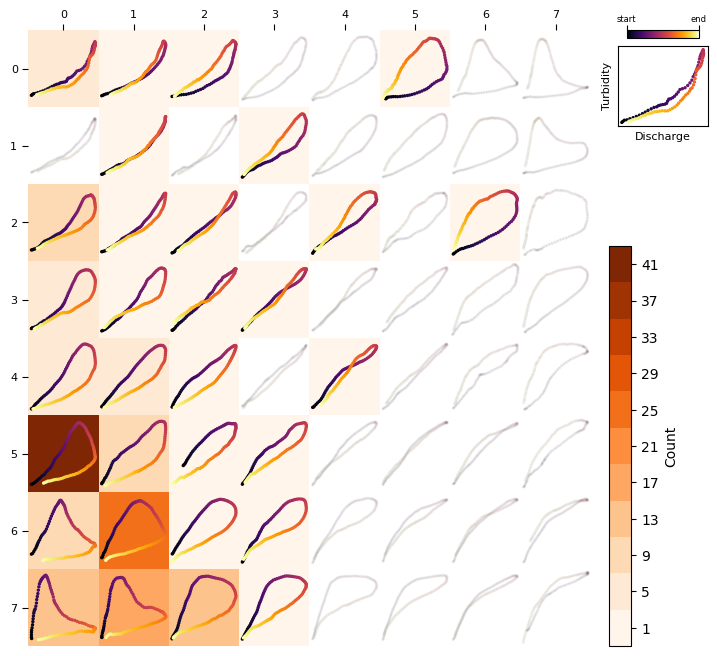

In [14]:
heatmap_frequency(TQsom, [ev.loop for ev in filtered_events], coordinates_style="matrix")

Let's plot now a heat map to visualize the association between loop types and discharge and tubidity:

In [36]:
loops,qmax,turbmax = zip(*[(ev.loop, ev.get_attribute("qmax"), ev.get_attribute("turbmax")) for ev in filtered_events ])

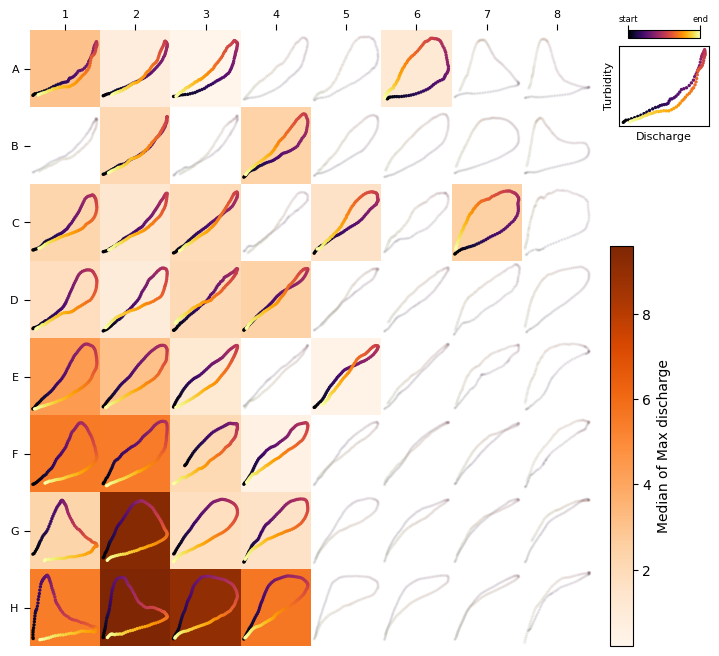

In [37]:
heat_map(TQsom, loops, qmax, colorbar_label="Median of Max discharge", agg_method=np.median)

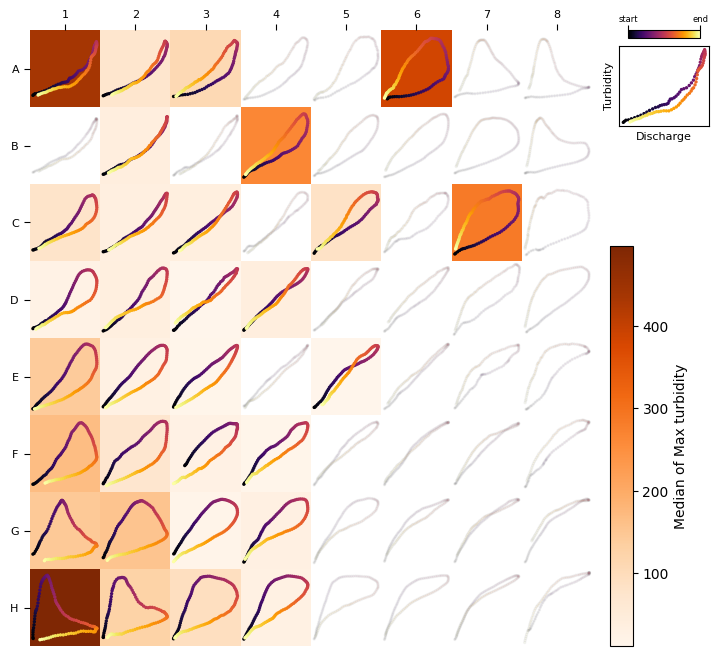

In [38]:
heat_map(TQsom, loops, turbmax, colorbar_label="Median of Max turbidity", agg_method=np.median)

You can also extract the frequency matrix and attribute matrices shown in the heatmaps:

In [39]:
TQsom.frequency_matrix([ev.loop for ev in filtered_events])

array([[ 6.,  1.,  1.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.],
       [11.,  2.,  1.,  0.,  1.,  0.,  1.,  0.],
       [ 5.,  2.,  1.,  1.,  0.,  0.,  0.,  0.],
       [ 6.,  6.,  2.,  0.,  1.,  0.,  0.,  0.],
       [41., 12.,  2.,  1.,  0.,  0.,  0.,  0.],
       [ 9., 26.,  2.,  3.,  0.,  0.,  0.,  0.],
       [15., 19., 15.,  1.,  0.,  0.,  0.,  0.]])

In [47]:

TQsom.attribute_matrix([ev.loop for ev in filtered_events], [ev.get_attribute("qmax") for ev in filtered_events]).round(2) # round to 2 decimals for visualization only

array([[3.04, 0.81, 0.21,  nan,  nan, 1.13,  nan,  nan],
       [ nan, 2.15,  nan, 2.41,  nan,  nan,  nan,  nan],
       [2.23, 1.27, 1.93,  nan, 1.6 ,  nan, 2.52,  nan],
       [1.79, 0.93, 2.05, 2.45,  nan,  nan,  nan,  nan],
       [4.4 , 3.09, 1.17,  nan, 0.43,  nan,  nan,  nan],
       [5.52, 5.47, 2.1 , 0.5 ,  nan,  nan,  nan,  nan],
       [2.33, 9.37, 1.72, 1.6 ,  nan,  nan,  nan,  nan],
       [5.44, 9.6 , 9.03, 5.64,  nan,  nan,  nan,  nan]])

In [46]:

TQsom.attribute_matrix([ev.loop for ev in filtered_events], [ev.get_attribute("turbmax") for ev in filtered_events]).round(2) # round to 2 decimals for visualization only

array([[437.  ,  72.7 , 110.  ,    nan,    nan, 384.  ,    nan,    nan],
       [   nan,  38.8 ,    nan, 265.  ,    nan,    nan,    nan,    nan],
       [ 78.4 ,  34.7 ,  37.5 ,    nan,  83.6 ,    nan, 285.  ,    nan],
       [ 26.  ,  36.25,  11.4 ,  38.7 ,    nan,    nan,    nan,    nan],
       [141.5 ,  29.55,  14.5 ,    nan,  12.2 ,    nan,    nan,    nan],
       [168.  ,  71.75,  26.85,  14.9 ,    nan,    nan,    nan,    nan],
       [146.  , 155.  ,  15.9 ,  30.7 ,    nan,    nan,    nan,    nan],
       [497.  , 126.  ,  92.5 ,  29.7 ,    nan,    nan,    nan,    nan]])